In the first section, we implemented the construction of the data loader, then let us implement the construction of a fully connected network $Y=WX+B$. Before starting the construction, let us first consider a few issues:  
$1$、Need to build a loss function:    
$$L(\mathbf{w}, b)=\frac{1}{n} \sum_{i=1}^n l^{(i)}(\mathbf{w}, b)=\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^{\top} \mathbf{x}^{(i)}+b-y^{(i)}\right)^2$$
$2$、It is necessary to define an optimization algorithm, that is, to optimize weight parameters $W$ and bias $b$ parameters through backpropagation. Here we choose the most basic gradient descent method：  

$$
\begin{gathered}
\mathbf{w} \leftarrow \mathbf{w}-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) \\
b \leftarrow b-\frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)
\end{gathered}
$$  

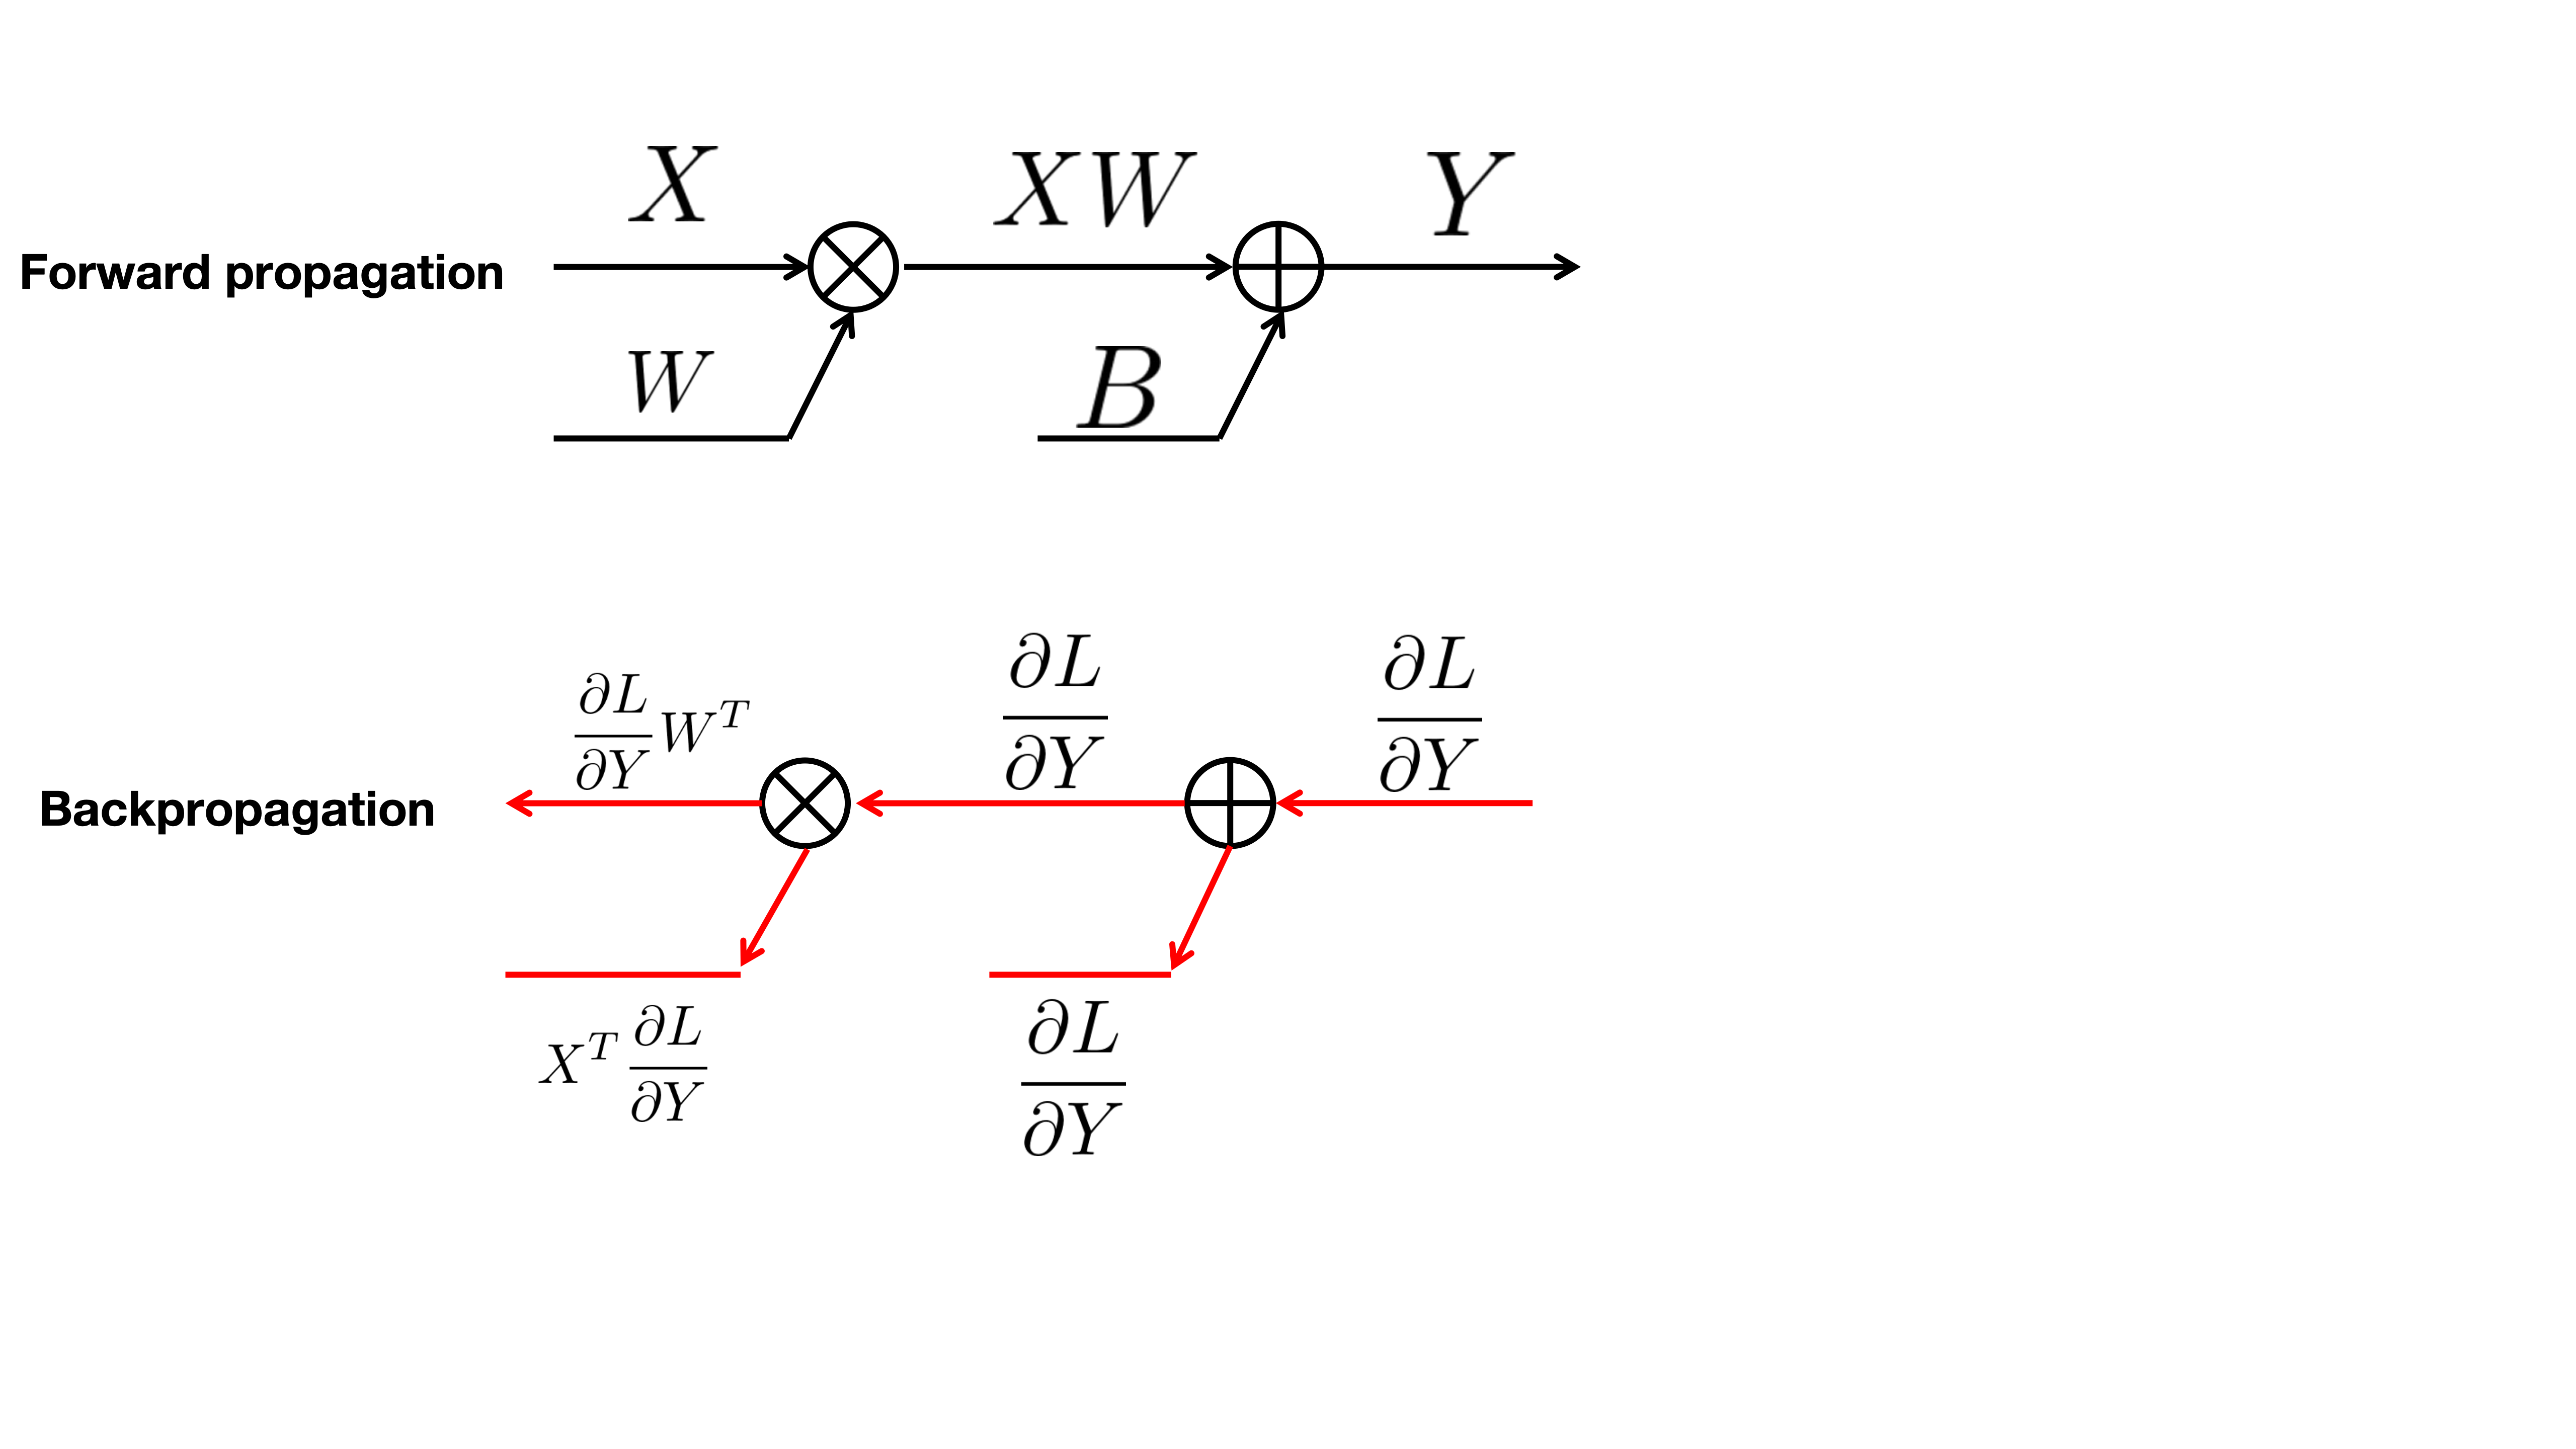   
$3$、In order to improve the nonlinear expression ability of the model, we usually introduce activation functions to increase nonlinear expression.  
$$\begin{aligned} f(x) & = \begin{cases}x & , x>=0 \\ 0 & , x<0\end{cases} \\ & =\max (0, x)\end{aligned}$$   
OK, then we first follow the above steps to build the loss function, optimizer (based on gradient descent method), and activation function (based on ReLU)


In [3]:
import torch

In [2]:
def loss(y_hat, y):
    return torch.mean((y_hat.reshape(y.shape) - y)**2 / 2)

In [3]:
y_hat = torch.randn(3, 1)
y = torch.randn(3, 1)
loss(y_hat, y)

tensor(0.9573)

When we build an optimizer, we need to use the concept of backpropagation (derivation). In PyTorch, this is how we perform backpropagation:  
$$e.g.   y = x^2$$   
In this example, we need to differentiate x, so when defining x, we need to use this parameter: __$requires  grad=True$__. This tensor needs to participate in the gradient calculation. This is so that the gradients of these tensors can be automatically calculated through the backpropagation algorithm during neural network training.

In [4]:
x = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = torch.dot(x, x)
y

tensor(14., grad_fn=<DotBackward0>)

In [5]:
# backward
y.backward()
x.grad

tensor([2., 4., 6.])

In [24]:
# gradient descent method
def sgd(params, lr, batch_size):
    with torch.no_grad():
        if isinstance(params, list):
            for i in range(len(params)):
                params[i] -= lr * params[i].grad / batch_size
                params[i].grad.zero_()
        else:
            params -= lr * params.grad / batch_size
            params.grad.zero_()

In [7]:
# relu
def relu(x):
    a = torch.zeros(x.shape)
    return torch.max(a, x)

OK, with the above basic components, we will start to build a fully connected network!

In [8]:
# Randomly generate our training samples and train labels
num_samples = 4000
num_features = 2
num_hiddens = 2
# train samples
X = torch.randn((num_samples, num_features), dtype=torch.float32)
X.shape

torch.Size([4000, 2])

In [9]:
true_W = torch.randn((num_hiddens, 1), dtype=torch.float32)
true_b = torch.randn(1, dtype=torch.float32)

In [10]:
Y = torch.mm(X, true_W) + true_b

In [11]:
Y.shape

torch.Size([4000, 1])

Our goal is to find the optimal W and b so that its calculated value $\hat{y}=xW+b$ (predicted value) is is closer to the true value $y$

In [12]:
# Randomly generate W and b and attach gradients
W = torch.normal(0, 0.01, size=(num_hiddens, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
W.shape, b.shape

(torch.Size([2, 1]), torch.Size([1]))

In [13]:
def fc(x, w, b):
    return relu(torch.mm(x, w) + b)

In [14]:
fc(X, W, b).shape

torch.Size([4000, 1])

Our fully connected layer has also been created. Now use the data loader we created previously to start training!

In [15]:
# Import our previous definition DataLoader
from utils.DataLoader import DataLoader

In [16]:
batch_size = 20
lr = 0.01
num_epochs = 20
dataloader = DataLoader(X, Y, batch_size, shuffle=True)

In [17]:
for epoch in range(num_epochs):
    for x, y in dataloader:
        l = loss(fc(x, W, b), y)  
        l.backward()
        sgd([W, b], lr, batch_size)  
    if (epoch+1) % 5 == 0:
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, l))


Epoch:5, Loss:0.5620
Epoch:10, Loss:0.1432
Epoch:15, Loss:0.1383
Epoch:20, Loss:0.0127


In [22]:
# Let’s check the difference between the final updated W,b and the real W,b
error_W = true_W - W
error_b = true_b - b    

In [23]:
error_W, error_b

(tensor([[0.1406],
         [0.1312]], grad_fn=<SubBackward0>),
 tensor([0.0983], grad_fn=<SubBackward0>))